In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

project_path = os.path.abspath('..')
if project_path not in sys.path:
    sys.path.append(project_path)

from MieSppForce.simulation import SimulationConfig, SweepRunner, Visualizer, DipoleCalculator, OpticalForceCalculator
import numpy as np
from pint import UnitRegistry
ureg = UnitRegistry()

base_config = SimulationConfig(
    wl = 900 * ureg.nanometer,
    R =  (295/2) * ureg.nanometer,
    dist = 2 * ureg.nanometer,
    angle = np.deg2rad(25),
    a_angle = np.pi/4,
    phase= np.pi/2
)

In [2]:
from MieSppForce import green_func_v2

green_func_v2.clear_cache()

In [3]:
from MieSppForce.simulation import CylindricalGrid, FieldsCalculator

grid = CylindricalGrid(
    r=np.linspace(0,2000, 100)*ureg.nm,
    phi=np.linspace(0, np.pi*2, 200)* ureg.radian,
    z=np.array([0.0]) * ureg.nm
)

gridFF = CylindricalGrid(
    r=20*base_config.wl,
    phi=np.linspace(0, np.pi*2, 200)* ureg.radian,
    z=np.array([0.0]) * ureg.nm
)

In [7]:
sweep_res, diagrams, _ = SweepRunner(base_config, 'wl', np.linspace(800, 1100, 100)*ureg.nanometer, True, True, True, False).run()

Sweeping 'wl': 100%|██████████| 100/100 [00:38<00:00,  2.59step/s]


In [10]:
sweep_res_air, diagrams_air, _ = SweepRunner(base_config, 'wl', np.linspace(800, 1100, 100)*ureg.nanometer, True, True, True, False, None, 'air').run()

Sweeping 'wl': 100%|██████████| 100/100 [00:35<00:00,  2.85step/s]


In [5]:
import numpy as np
import matplotlib.pyplot as plt

diagrams_air["phi"] = diagrams_air["phi"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)
diagrams_air["wl"]  = diagrams_air["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)

pivot_air = diagrams_air.pivot(index="phi", columns="wl", values="D")

plt.figure(figsize=(5, 3), dpi=300)

plt.imshow(
    pivot_air.values.astype(float),
    aspect="auto",
    origin="lower",
    extent=[
        float(pivot_air.columns.min()), float(pivot_air.columns.max()),
        float(pivot_air.index.min()),   float(pivot_air.index.max())
    ],
    cmap="hot",
    vmin=0, vmax=2.5
)

plt.colorbar(label="D")
plt.xlabel("$\\lambda$ (nm)")
plt.ylabel("$\\varphi$ (rad)")
plt.title("Распределение $D_{air}$ (Theory)")

# Установка делений по оси Y в радианах
yticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
yticklabels = ["$0$", "$\\pi/2$", "$\\pi$", "$3\\pi/2$", "$2\\pi$"]

plt.yticks(yticks, yticklabels)

plt.tight_layout()
#plt.savefig('field/D_map_air.png', dpi=300)
plt.show()

NameError: name 'diagrams_air' is not defined

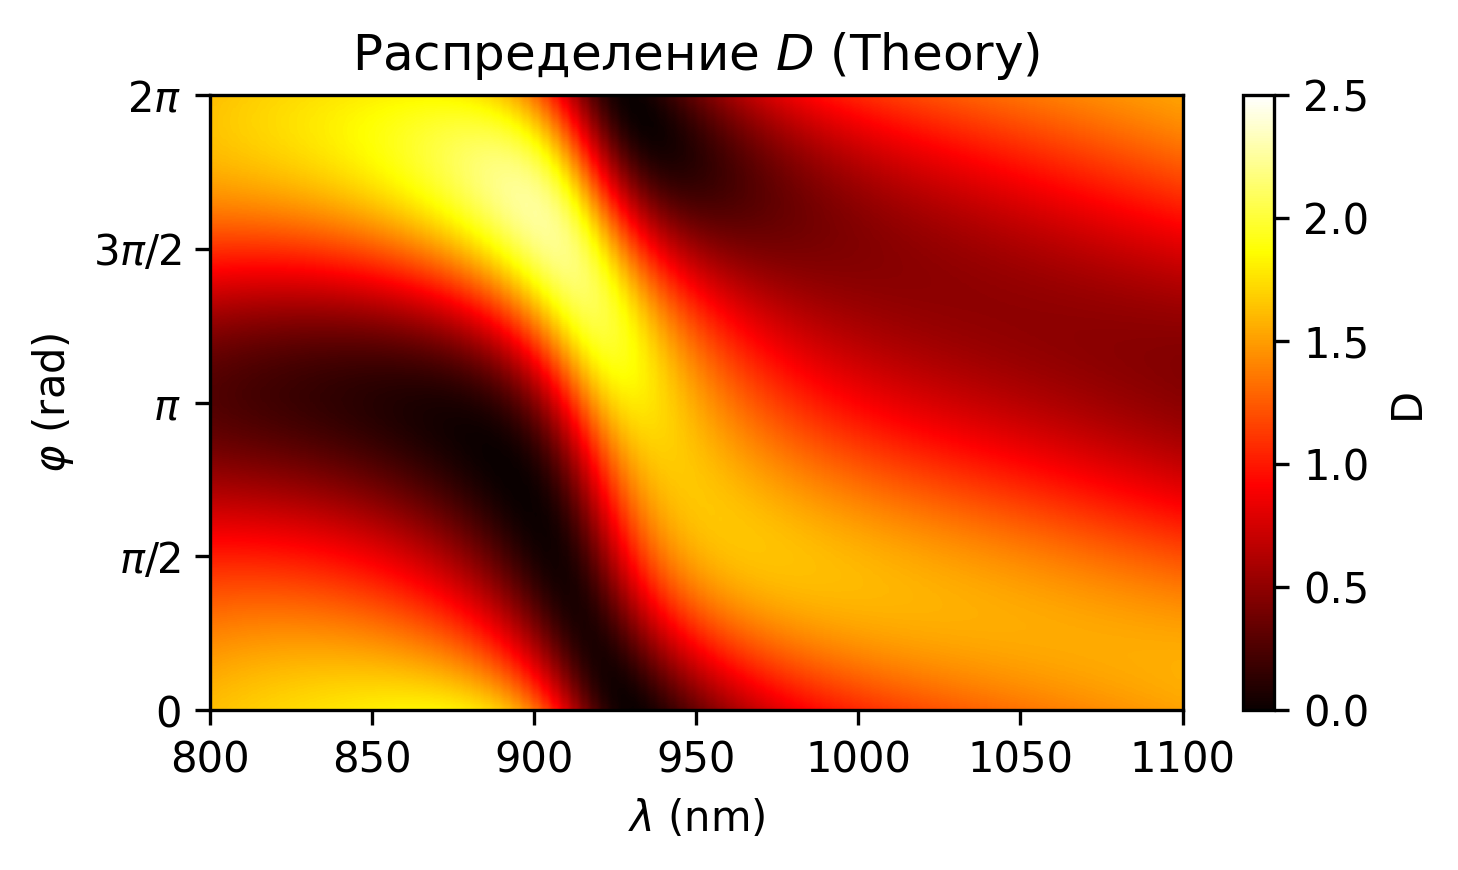

In [8]:
import numpy as np
import matplotlib.pyplot as plt

diagrams["phi"] = diagrams["phi"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)
diagrams["wl"]  = diagrams["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)

pivot = diagrams.pivot(index="phi", columns="wl", values="D")

plt.figure(figsize=(5, 3), dpi=300)

plt.imshow(
    pivot.values.astype(float),
    aspect="auto",
    origin="lower",
    extent=[
        float(pivot.columns.min()), float(pivot.columns.max()),
        float(pivot.index.min()),   float(pivot.index.max())
    ],
    cmap="hot",
    vmin=0, vmax=2.5
)

plt.colorbar(label="D")
plt.xlabel("$\\lambda$ (nm)")
plt.ylabel("$\\varphi$ (rad)")
plt.title("Распределение $D$ (Theory)")

# Установка делений по оси Y в радианах
yticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
yticklabels = ["$0$", "$\\pi/2$", "$\\pi$", "$3\\pi/2$", "$2\\pi$"]

plt.yticks(yticks, yticklabels)

plt.tight_layout()
#plt.savefig('field/D_map.png', dpi=300)
plt.show()

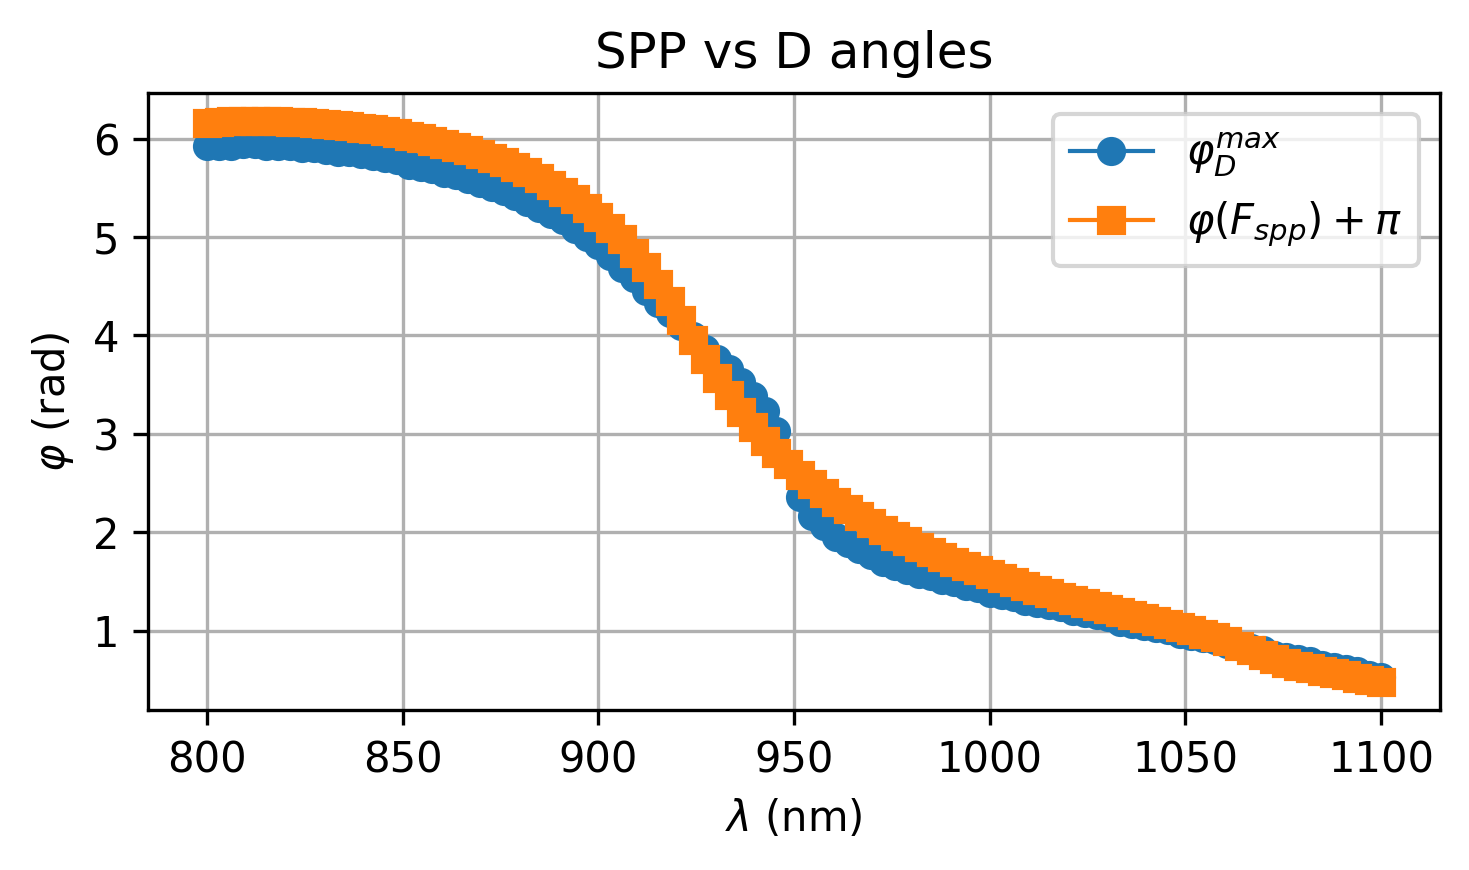

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. phi_max из диаграмм ---
diagrams["phi"] = diagrams["phi"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)
diagrams["wl"]  = diagrams["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)

phi_max = (
    diagrams.loc[diagrams.groupby("wl")["D"].idxmax()][["wl", "phi"]]
    .rename(columns={"phi": "phi_max"})
)

# --- 2. Угол силы ---
Fx = sweep_res["Fx"].apply(lambda x: x.to("N").magnitude).to_numpy()
Fy = sweep_res["Fy"].apply(lambda x: x.to("N").magnitude).to_numpy()
wl = sweep_res["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

Fxe0 = sweep_res["Fxe0"].apply(lambda x: x.to("N").magnitude).to_numpy()
Fxm0 = sweep_res["Fxm0"].apply(lambda x: x.to("N").magnitude).to_numpy()

Fxcross = sweep_res["Fxcross"].apply(lambda x: x.to("N").magnitude).to_numpy()
Fycross = sweep_res["Fycross"].apply(lambda x: x.to("N").magnitude).to_numpy()

Fx_nosc = Fx - Fxe0 - Fxm0

Fx_nosc_noncross = Fx_nosc - Fxcross
Fy_nosc_noncross = Fy - Fycross

Fxspp = sweep_res["Fxspp"].apply(lambda x: x.to("N").magnitude).to_numpy()
Fyspp = sweep_res["Fyspp"].apply(lambda x: x.to("N").magnitude).to_numpy()


theta_F = np.arctan2(Fy, Fx)

theta_F_nosc = np.arctan2(Fy, Fx_nosc)

theta_F_nosc_noncross = np.arctan2(Fy_nosc_noncross, Fx_nosc_noncross)

theta_F_spp = np.arctan2(Fyspp, Fxspp)


df_forces = pd.DataFrame({"wl": wl, "theta_F": theta_F_spp})

# --- 3. Совмещение ---
df_plot = pd.merge(phi_max, df_forces, on="wl")


# --- 4. Построение ---
plt.figure(figsize=(5,3), dpi=300)
plt.plot(df_plot["wl"], df_plot["phi_max"], label="$\\varphi_D^{max}$", marker="o", lw=1)
plt.plot(df_plot["wl"], df_plot["theta_F"]+np.pi, label="$\\varphi(F_{spp})+\\pi$", marker="s", lw=1)

# plt.plot(df_plot["wl"], np.abs(df_plot["phi_max"]-df_plot["theta_F"]-np.pi), label="delta phi", marker="o")


plt.xlabel("$\\lambda$ (nm)")
plt.ylabel("$\\varphi$ (rad)")
plt.title("SPP vs D angles")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('field/SPP_F_angles.png', dpi=300)
plt.show()

In [15]:
#Free Space

base_config_free_space = SimulationConfig(
    wl = 900 * ureg.nanometer,
    R =  (295/2) * ureg.nanometer,
    dist = 2 * ureg.nanometer,
    angle = np.deg2rad(0),
    a_angle = 0,
    phase= 0,
    substrate='Air'
)

sweep_res_free_space, _, _ = SweepRunner(base_config_free_space, 'wl', np.linspace(800, 1100, 100)*ureg.nanometer, True, False, True, False).run()



Sweeping 'wl': 100%|██████████| 100/100 [00:03<00:00, 27.24step/s]


In [12]:
fxfy_comsol = np.loadtxt('fx_fy.txt', delimiter=',')

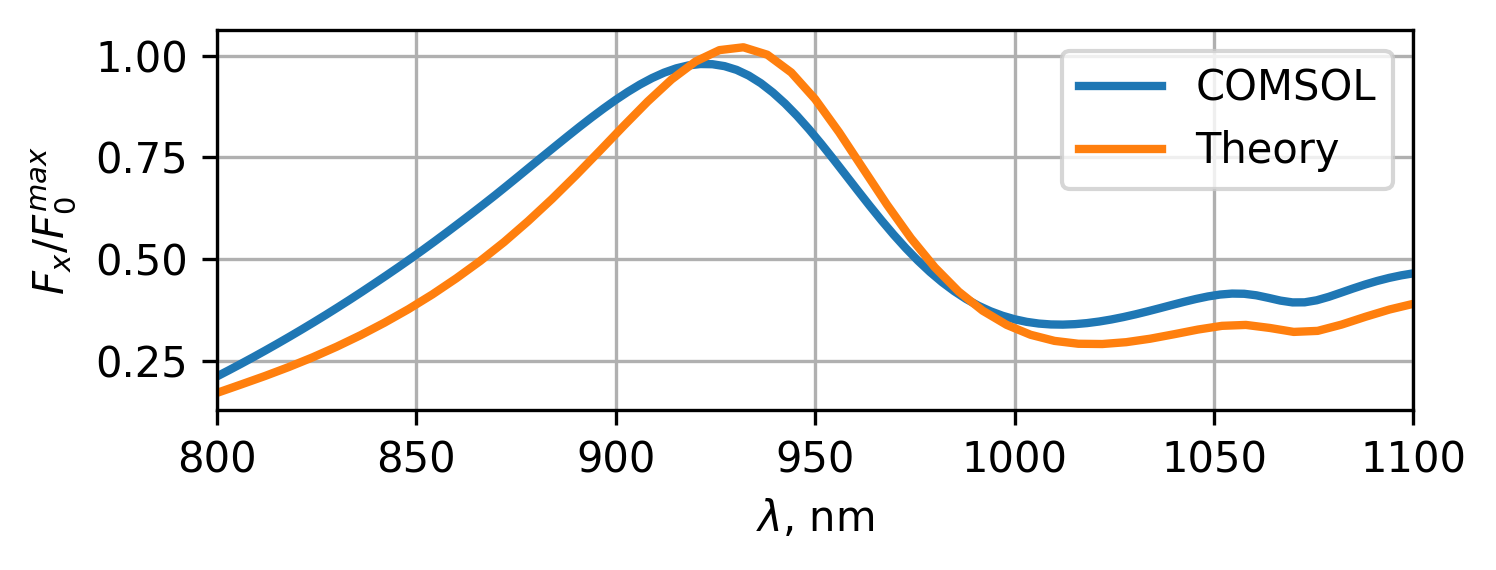

In [46]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(wl, Fx/F0.magnitude, label='COMSOL', lw=2)
plt.plot(fxfy_comsol[:,0], fxfy_comsol[:,1]/F0, label='Theory', lw=2)
plt.ylabel('$F_x/F_0^{max}$')
plt.xlabel('$\\lambda$, nm')
plt.legend()
plt.grid()
plt.xlim(wl[0], wl[-1])
plt.tight_layout()
plt.savefig('Fx_coms_python.png')


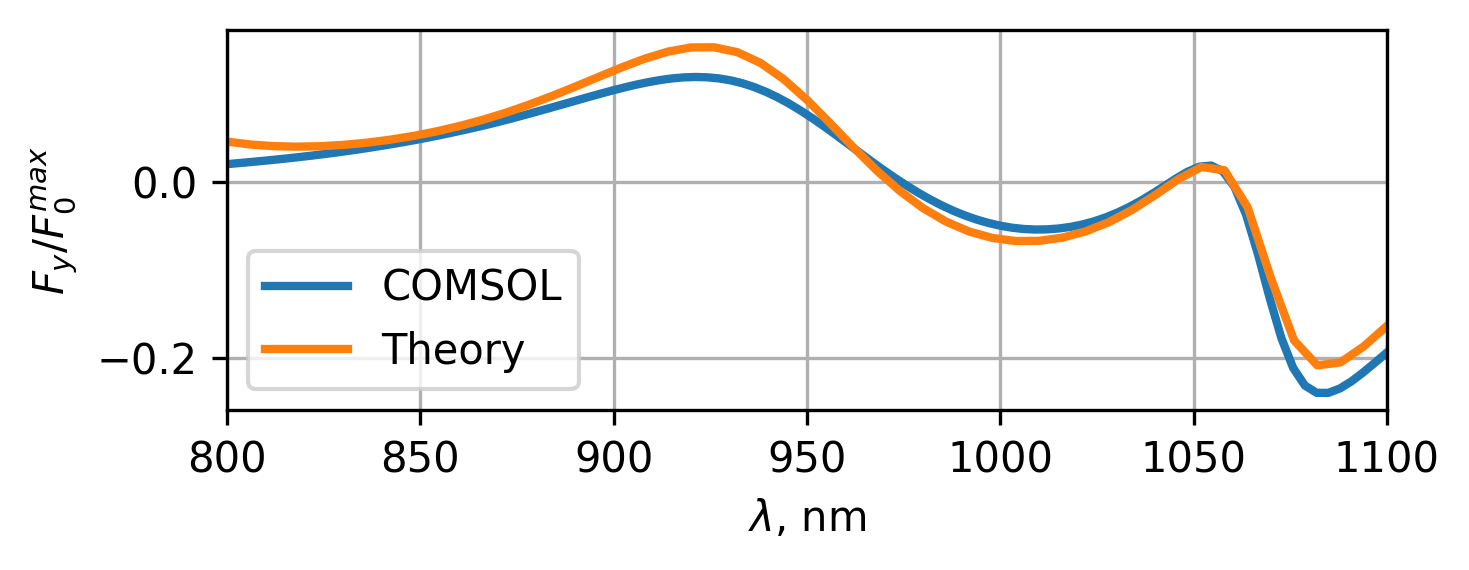

In [45]:

plt.figure(figsize=(5,2), dpi=300)
plt.plot(wl, Fy/F0.magnitude, label='COMSOL', lw=2)
plt.plot(fxfy_comsol[:,0], fxfy_comsol[:,2]/F0, label='Theory', lw=2)
plt.ylabel('$F_y/F_0^{max}$')
plt.xlabel('$\\lambda$, nm')
plt.legend()
plt.grid()
plt.xlim(wl[0], wl[-1])
plt.tight_layout()
plt.savefig('Fy_coms_python.png')



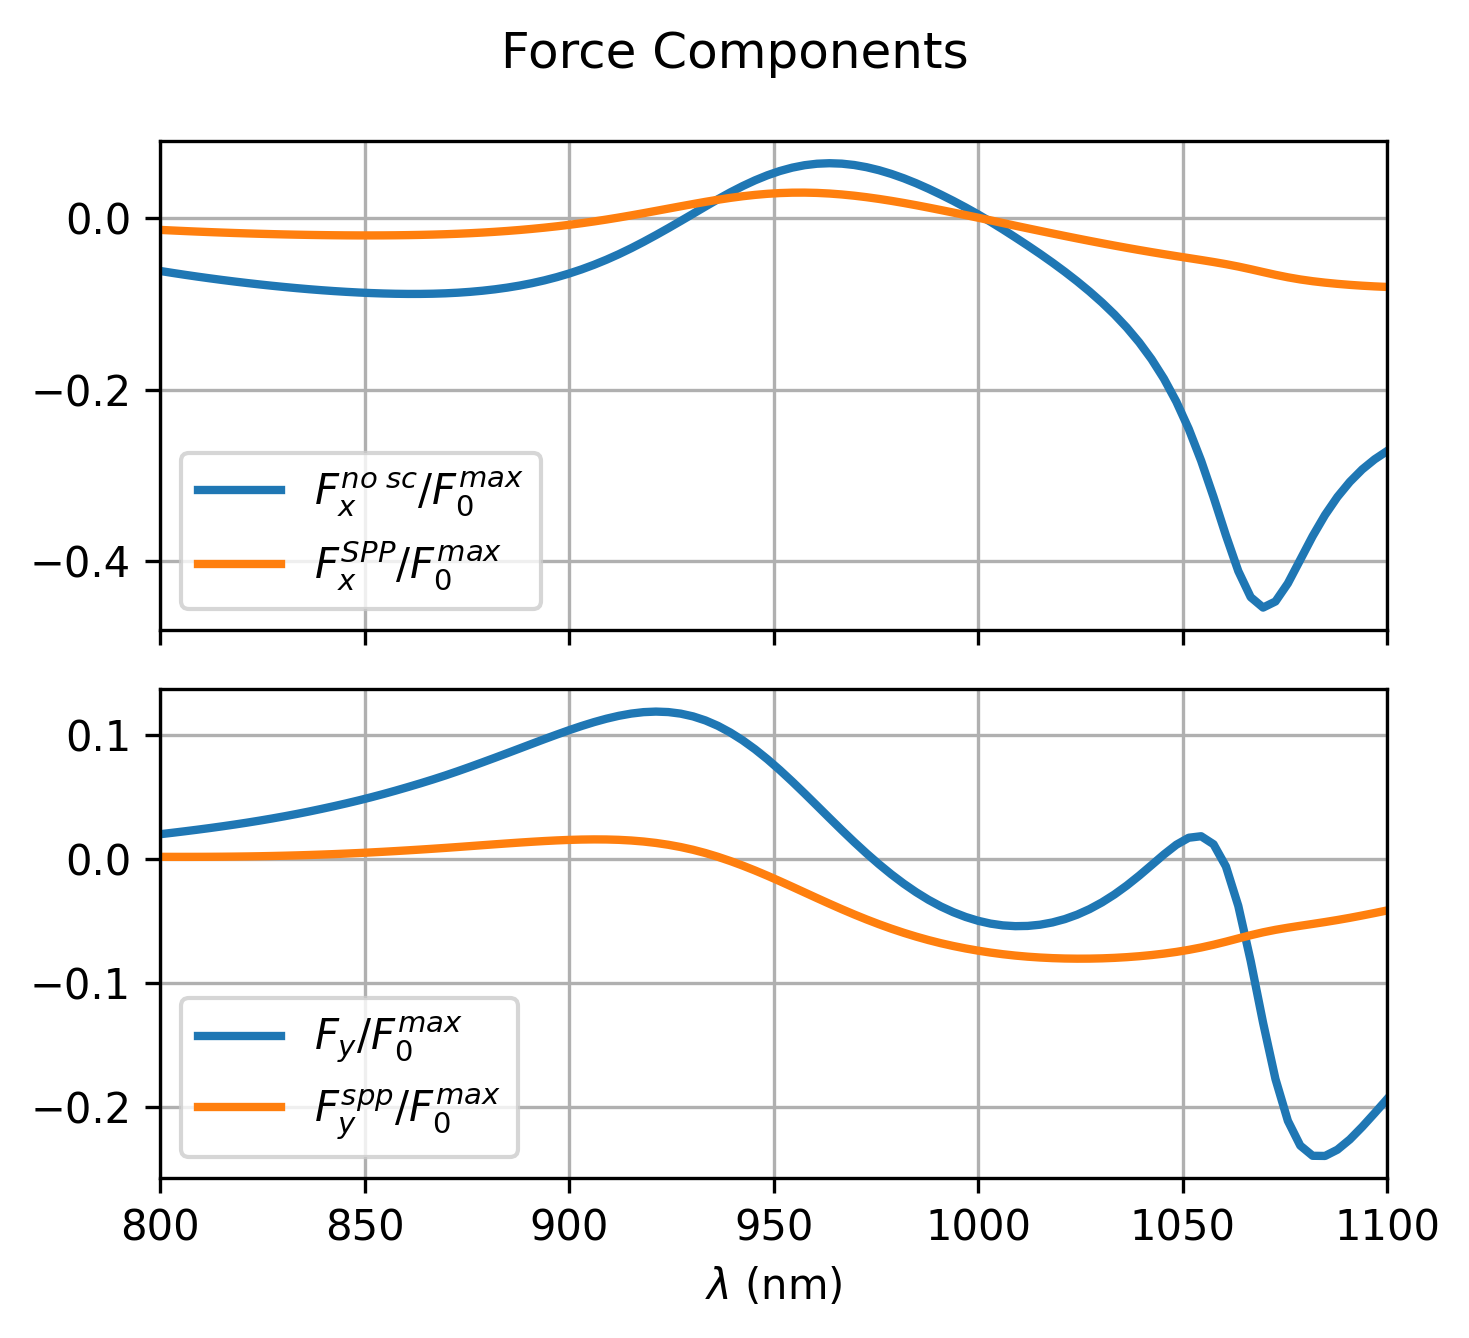

In [68]:
import numpy as np
import matplotlib.pyplot as plt

F0 = np.max(np.abs(sweep_res_free_space['Fz'].to_numpy()))

# --- 2. Угол силы ---
Fx = sweep_res["Fx"].to_numpy()
Fy = sweep_res["Fy"].to_numpy()
wl = sweep_res["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

Fxe0 = sweep_res["Fxe0"].to_numpy()
Fxm0 = sweep_res["Fxm0"].to_numpy()

Fxcross = sweep_res["Fxcross"].to_numpy()
Fycross = sweep_res["Fycross"].to_numpy()

Fx_nosc = Fx - Fxe0 - Fxm0

Fx_nosc_noncross = Fx_nosc - Fxcross
Fy_nosc_noncross = Fy - Fycross


Fxspp = sweep_res["Fxspp"].to_numpy()
Fyspp = sweep_res["Fyspp"].to_numpy()



Fx_norm      = np.array([f / F0 for f in Fx])
Fxnosc_norm  = np.array([f / F0 for f in Fx_nosc])
Fxnocross_norm = np.array([f / F0 for f in Fx_nosc_noncross])
Fxspp_norm   =  np.array([f / F0 for f in Fxspp])

Fy_norm      =  np.array([f / F0 for f in Fy])
Fynocross_norm =np.array([f / F0 for f in Fy_nosc_noncross])
Fyspp_norm   = np.array([f / F0 for f in Fyspp])

# --- графики ---
fig, axs = plt.subplots(2, 1, figsize=(5, 4.5),dpi=300, sharex=True)

#  X-компонента
#axs[0].plot(wl, Fx_norm, label="Fx / F0", marker="o")
axs[0].plot(wl, Fxnosc_norm, label="$F_x^{no\\;sc}/F_0^{max}$", lw=2)
#axs[0].plot(wl, Fxnocross_norm, label="Fx_nosc_nocross / F0", lw=2)
axs[0].plot(wl, Fxspp_norm, label="$F_x^{SPP} / F_0^{max}$", lw=2)
# axs[0].set_ylabel("$F_x^{spp} / F_0^{max}$")
axs[0].legend()
axs[0].grid(True)

# Y-компонента
axs[1].plot(wl, Fy_norm, label="$F_y / F_0^{max}$", lw=2)
# axs[1].plot(wl, Fynocross_norm, label="Fy_nosc_nocross / F0", marker="^")
axs[1].plot(wl, Fyspp_norm, label="$F_y^{spp} / F_0^{max}$", lw=2)
# axs[1].set_ylabel("$F_y^{spp}$ / $F_0^{max}$")
axs[1].set_xlabel("$\\lambda$ (nm)")
axs[1].legend()
axs[1].grid(True)

axs[0].set_xlim(wl[0],wl[-1])

plt.suptitle("Force Components")
plt.tight_layout()
plt.savefig('field/F_nosc_and_SPP_Force_Components.png', dpi=300)
plt.show()

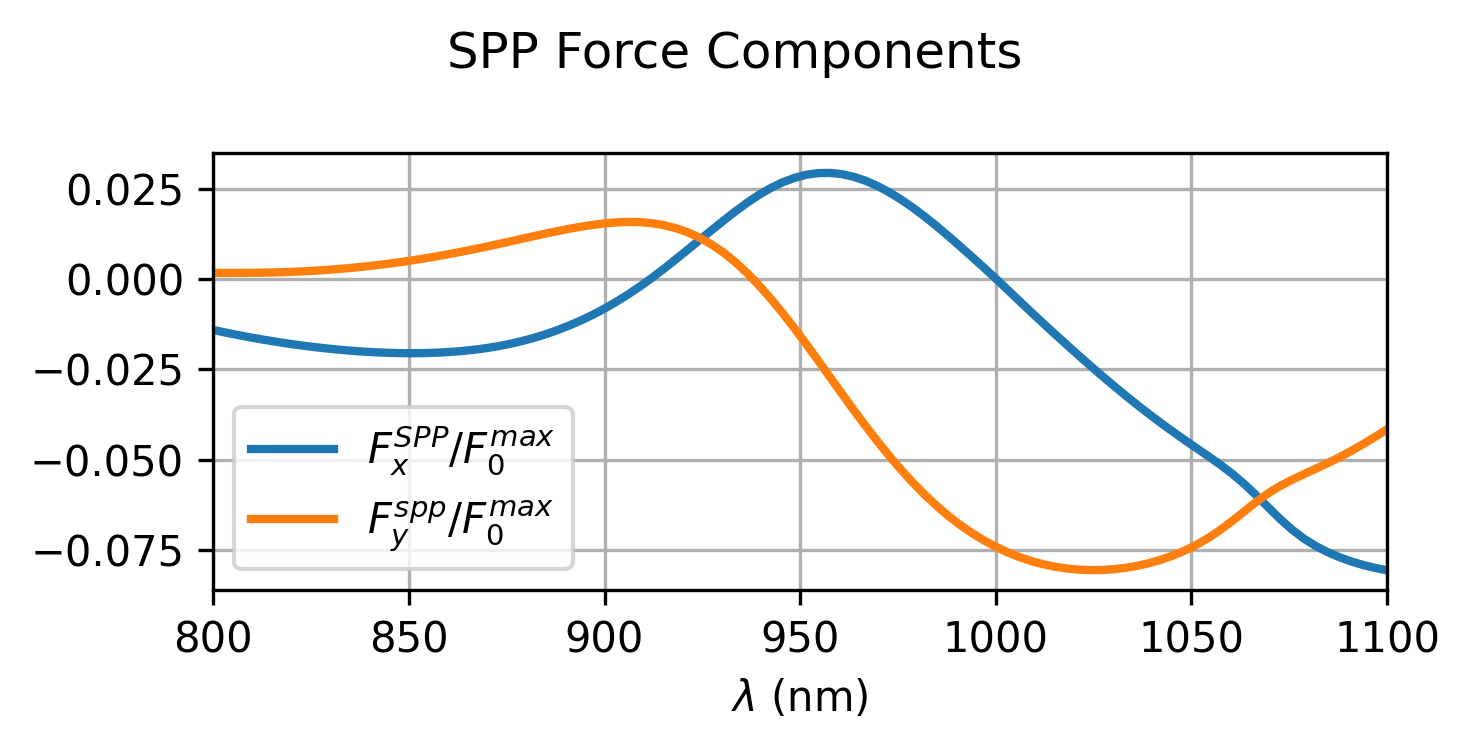

In [73]:

# --- графики ---
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5),dpi=300, sharex=True)

ax.plot(wl, Fxspp_norm, label="$F_x^{SPP} / F_0^{max}$", lw=2)
ax.plot(wl, Fyspp_norm, label="$F_y^{spp} / F_0^{max}$", lw=2)

ax.set_xlabel("$\\lambda$ (nm)")
ax.legend()
ax.grid(True)

ax.set_xlim(wl[0],wl[-1])

plt.suptitle("SPP Force Components")
plt.tight_layout()
plt.savefig('field/SPP_Force_Components.png', dpi=300)
plt.show()

In [3]:
from MieSppForce import green_func_v2, frenel, green_func

from tqdm import tqdm
wl=800
# epsConst = -24.061488741942565+1.5068228110835038*1j
epsAu = frenel.get_interpolate('Au')
z0=20
z=10
h = z + z0
rs = np.linspace(2000,3000,100)
phi = np.pi/4

GE = np.zeros((len(rs),3,3), dtype=complex)

for i,r in tqdm(enumerate(rs)):
    GEi, rotGHi, GHi, rotGEi = green_func_v2.getG(wl, epsAu, h, r, phi)
    GE[i,:,:] = GEi


42it [01:57,  2.95s/it]c:\Users\borod\Desktop\SPP_ANALYTICAL\SPP_ANALYTICAL\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:444: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  im_retval = quad(imfunc, a, b, args, full_output, epsabs,
46it [02:10,  3.04s/it]c:\Users\borod\Desktop\SPP_ANALYTICAL\SPP_ANALYTICAL\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:441: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  re_retval = quad(refunc, a, b, args, full_output, epsabs,
100it [05:12,  3.12s/it]


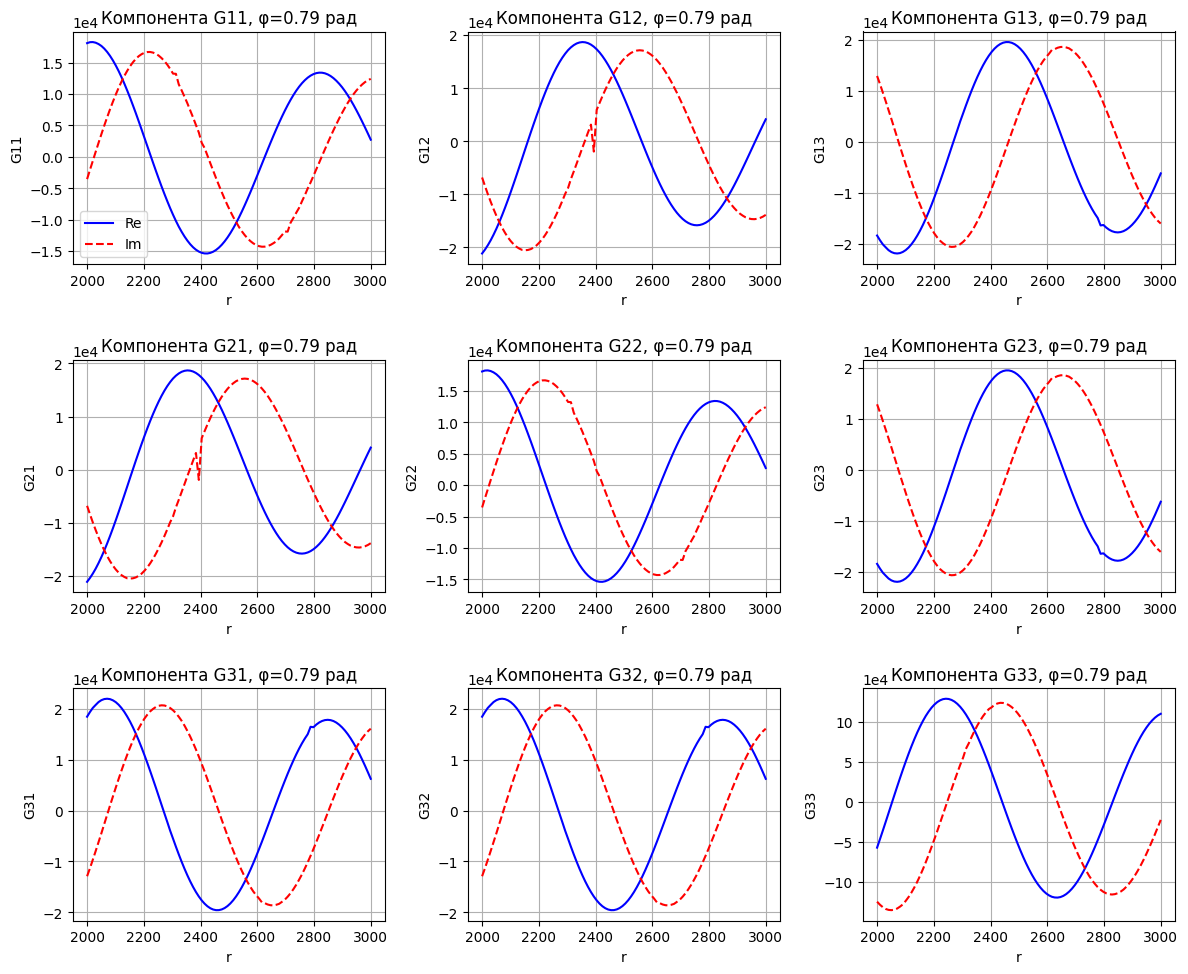

In [4]:
# --- построение графиков ---
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
for row in range(3):
    for col in range(3):
        ax = axes[row, col]
        ax.plot(rs, GE[:, row, col].real, 'b-', label='Re')
        ax.plot(rs, GE[:, row, col].imag, 'r--', label='Im')
        ax.set_xlabel("r")
        ax.set_ylabel(f"G{row+1}{col+1}")
        ax.set_title(f"Компонента G{row+1}{col+1}, φ={phi:.2f} рад")
        ax.grid(True)
        ax.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
        if row == 0 and col == 0:
            ax.legend()

plt.tight_layout()
plt.show()

In [75]:
p_coms = np.loadtxt('p_wl.txt', delimiter=',')
m_coms = np.loadtxt('m_wl.txt', delimiter=',')

In [76]:
px= sweep_res['px'].apply(lambda x: x.to('C*m').magnitude).to_numpy()
py = sweep_res['py'].apply(lambda x: x.to('C*m').magnitude).to_numpy()
pz = sweep_res['pz'].apply(lambda x: x.to('C*m').magnitude).to_numpy()

mx = sweep_res['mx'].apply(lambda x: x.to('A*m**2').magnitude).to_numpy()
my = sweep_res['my'].apply(lambda x: x.to('A*m**2').magnitude).to_numpy()
mz = sweep_res['mz'].apply(lambda x: x.to('A*m**2').magnitude).to_numpy()


wls = sweep_res['wl'].apply(lambda x: x.to('nm').magnitude).to_numpy()

Text(0, 0.5, 'p, C*m')

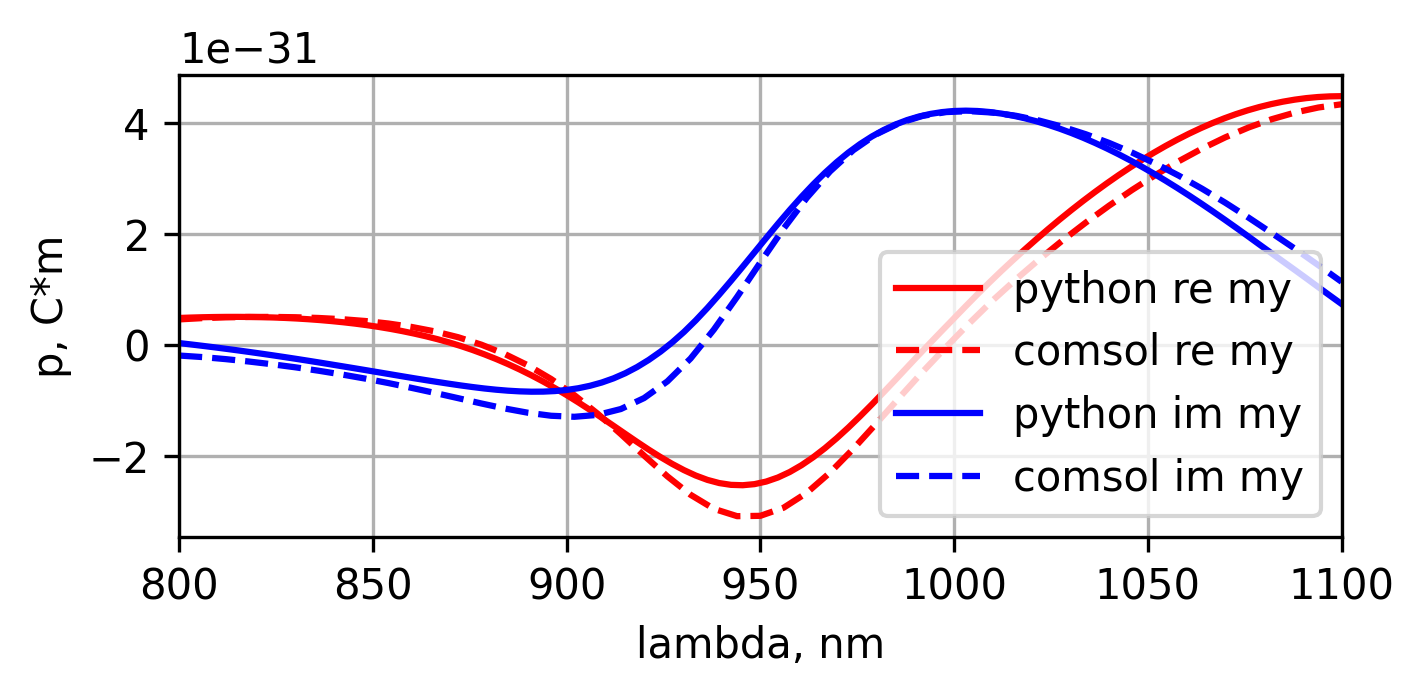

In [78]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(wls, my.real/base_config.c_const, label='python re my', c='r')
plt.plot(m_coms[:,0], m_coms[:,3]/base_config.c_const, c='r', ls='--', label='comsol re my')

plt.plot(wls, my.imag/base_config.c_const, c='b', label='python im my')
plt.plot(m_coms[:,0], -m_coms[:,4]/base_config.c_const, c='b', ls='--', label='comsol im my')
plt.xlim(800,1100)
plt.grid()
plt.legend()
plt.xlabel('lambda, nm')
plt.ylabel('p, C*m')

Text(0, 0.5, 'p, C*m')

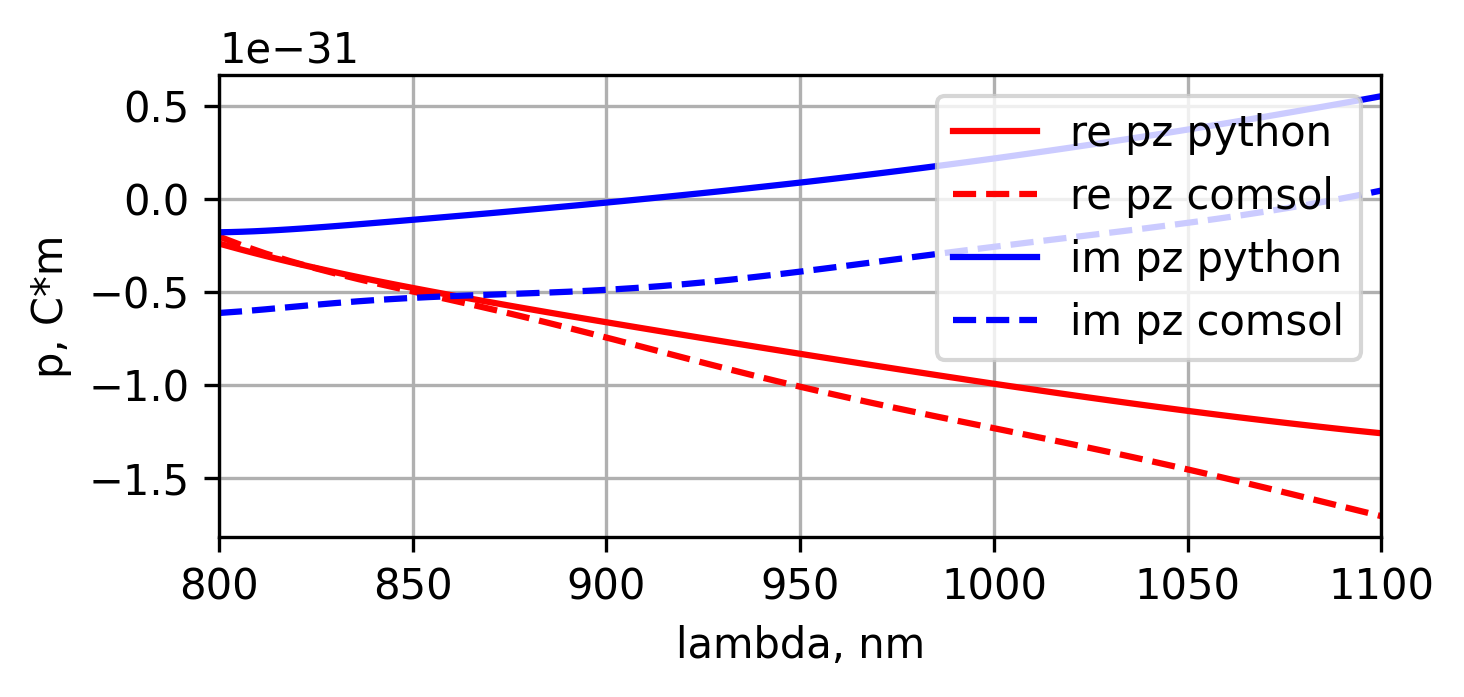

In [79]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(wls, pz.real, label='re pz python', c='r')
plt.plot(p_coms[:,0], p_coms[:,5], c='r', ls='--', label='re pz comsol')

plt.plot(wls, pz.imag, c='b', label='im pz python')
plt.plot(p_coms[:,0], -p_coms[:,6], c='b', ls='--', label='im pz comsol')
plt.xlim(800,1100)
plt.grid()
plt.legend()
plt.xlabel('lambda, nm')
plt.ylabel('p, C*m')

Text(0, 0.5, 'p, C*m')

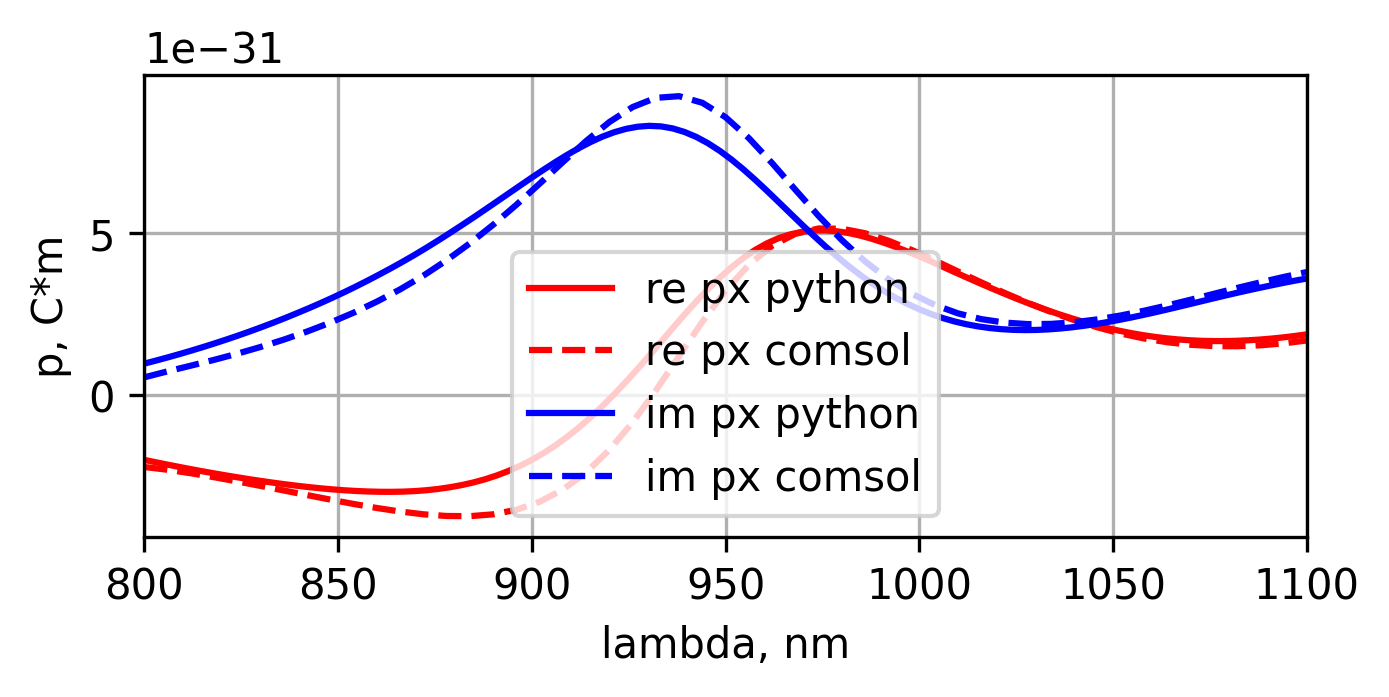

In [80]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(wls, px.real, label='re px python', c='r')
plt.plot(p_coms[:,0], p_coms[:,1], c='r', ls='--', label='re px comsol')

plt.plot(wls, px.imag, c='b', label='im px python')
plt.plot(p_coms[:,0], -p_coms[:,2], c='b', ls='--', label='im px comsol')
plt.xlim(800,1100)
plt.grid()
plt.legend()
plt.xlabel('lambda, nm')
plt.ylabel('p, C*m')

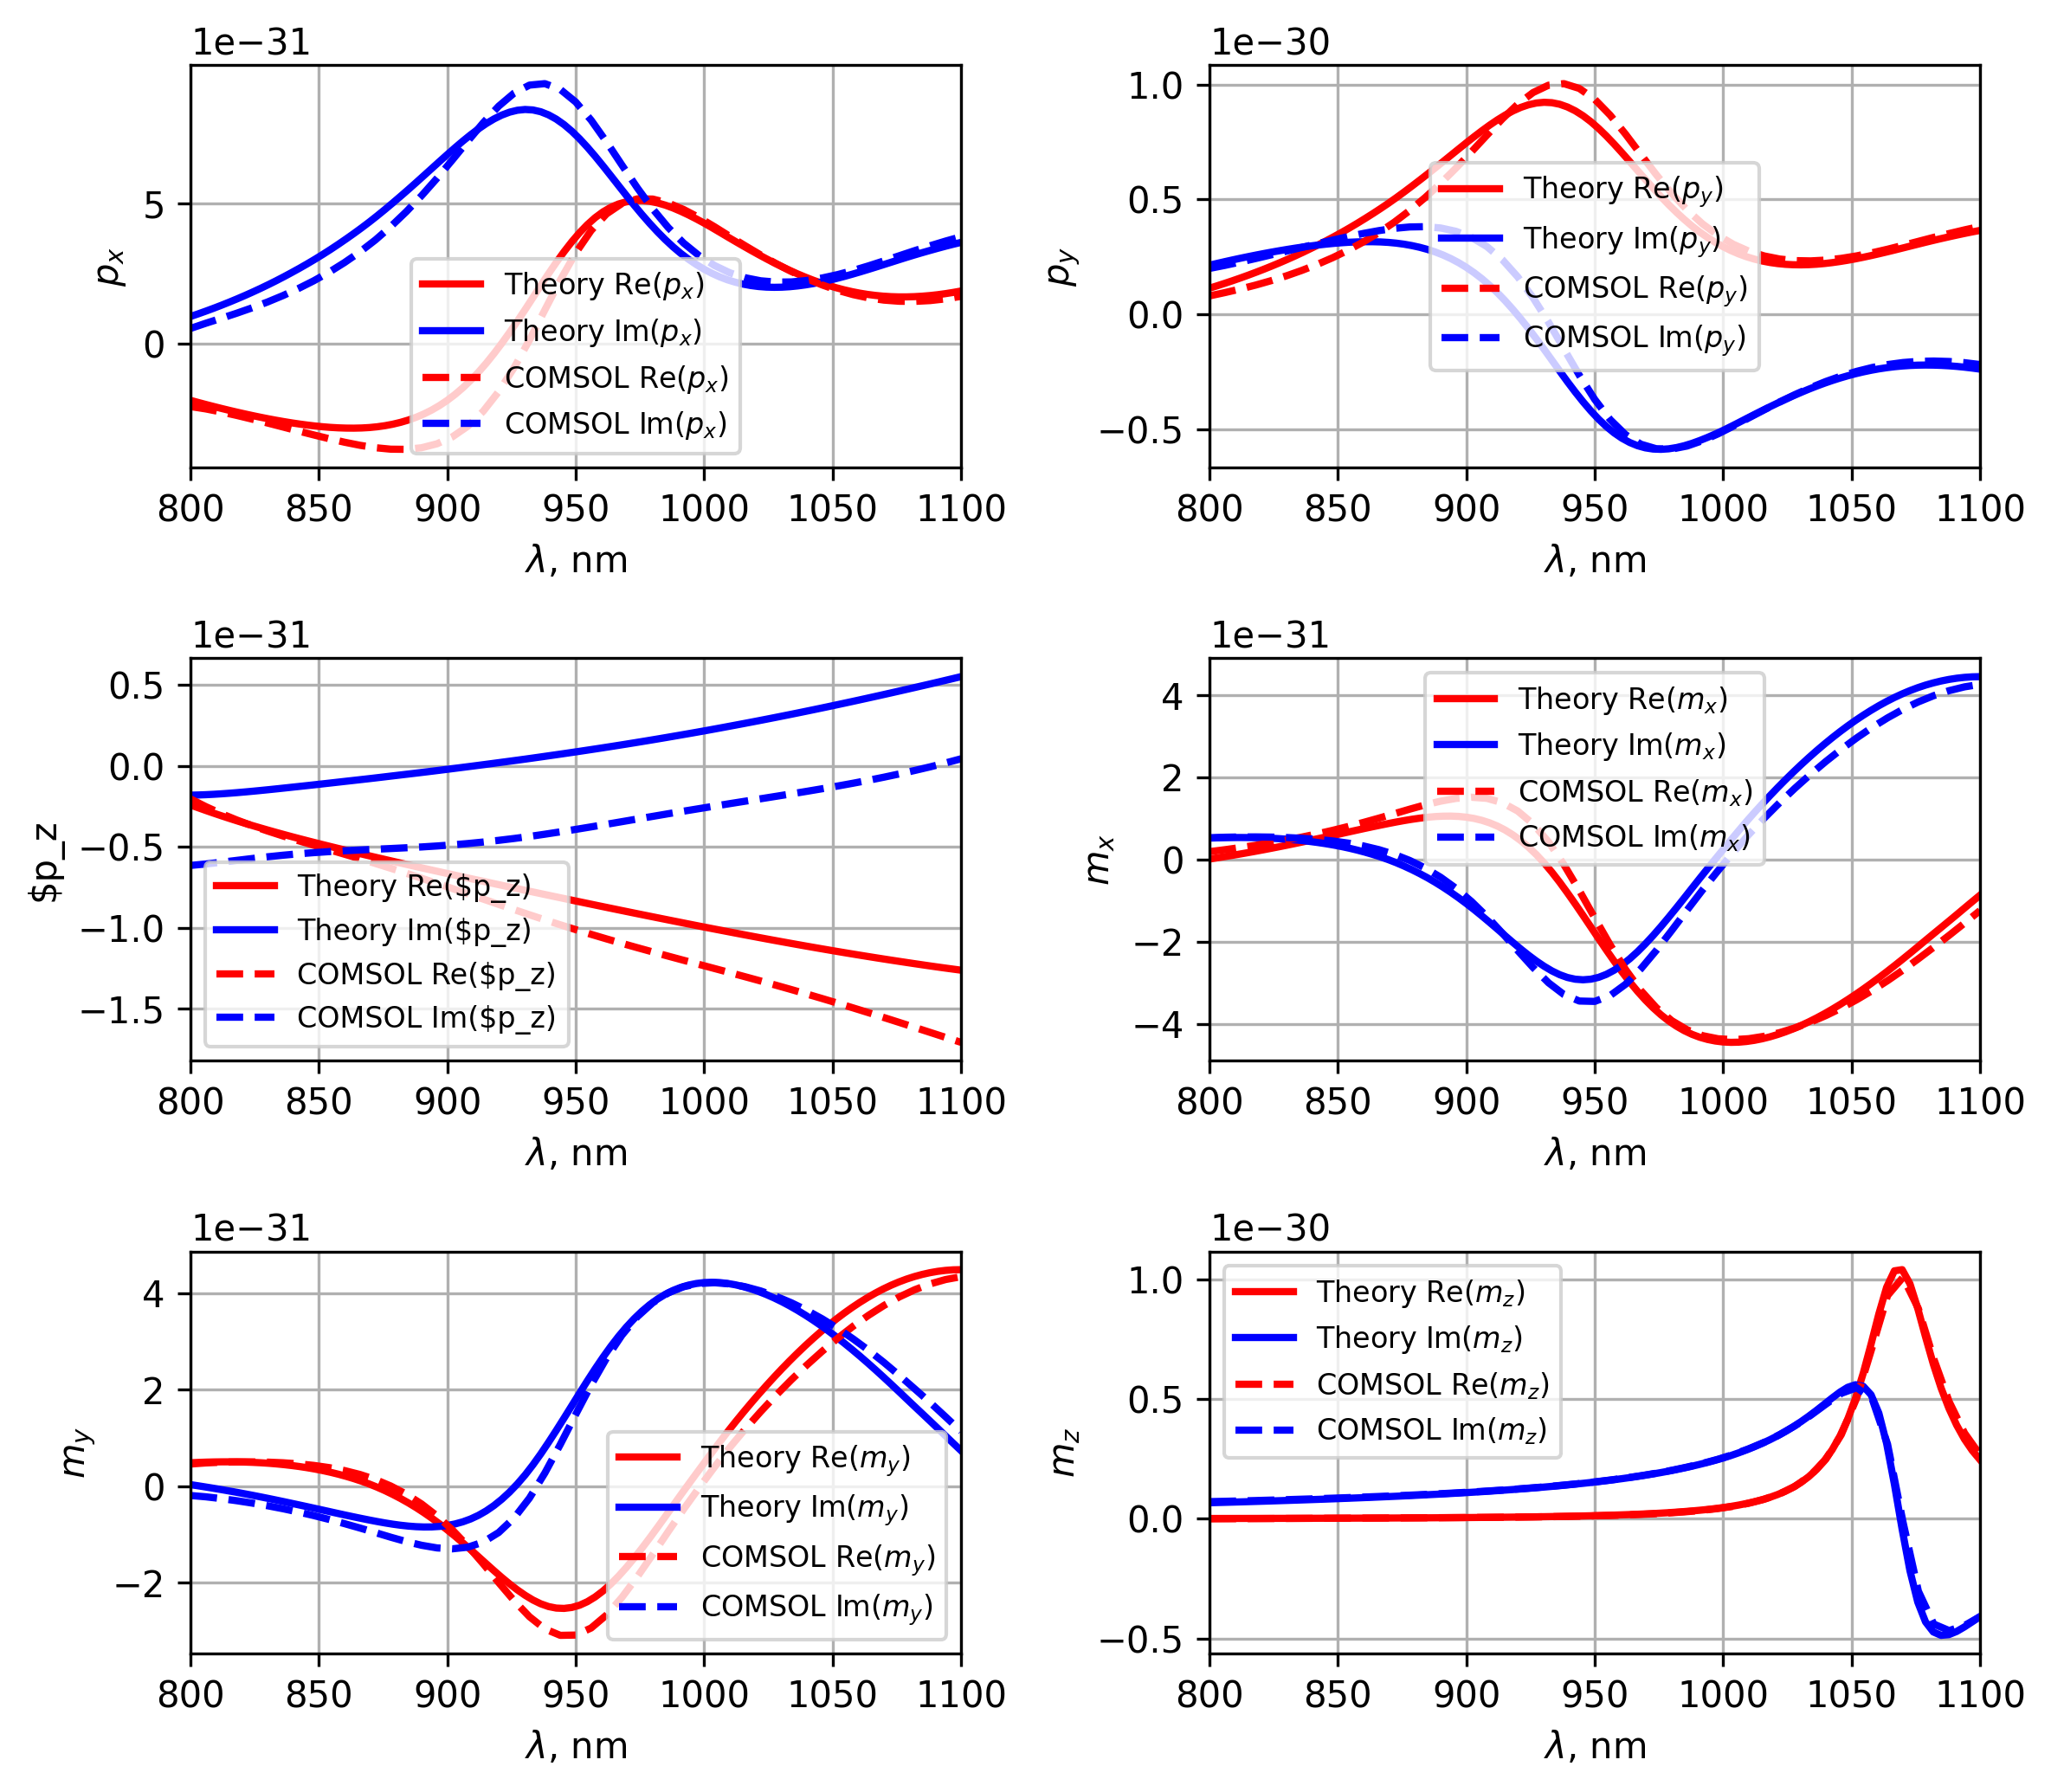

In [94]:
import matplotlib.pyplot as plt

# создаём 3х2 сетку
fig, axes = plt.subplots(3, 2, figsize=(8, 7), dpi=300)
axes = axes.ravel()

# список компонент и подписей (Python, массив Comsol, индекс real, индекс imag, нормировка)
components = [
    (px, p_coms, 1, 2, 1, '$p_x$'),
    (py, p_coms, 3, 4, 1, '$p_y$'),
    (pz, p_coms, 5, 6, 1, '$p_z'),
    (mx, m_coms, 1, 2, base_config.c_const, '$m_x$'),
    (my, m_coms, 3, 4, base_config.c_const, '$m_y$'),
    (mz, m_coms, 5, 6, base_config.c_const, '$m_z$')
]

# отрисовка
for ax, (comp, coms, idx_re, idx_im, norm, label) in zip(axes, components):
    ax.plot(wls, comp.real/norm, 'r', label=f'Theory Re({label})', lw=2)
    ax.plot(wls, comp.imag/norm, 'b', label=f'Theory Im({label})', lw=2)

    ax.plot(coms[:,0], coms[:,idx_re]/norm, 'r--', label=f'COMSOL Re({label})', lw=2)
    ax.plot(coms[:,0], -coms[:,idx_im]/norm, 'b--', label=f'COMSOL Im({label})', lw=2)
    
    ax.set_xlim(800, 1100)
    ax.set_xlabel('$\\lambda$, nm')
    ax.set_ylabel(label)
    ax.grid()
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('dipoles_compare.png')
plt.show()


In [ ]:
dips = DipoleCalculator(base_config).compute()

In [ ]:
dips

In [ ]:
FarField = FieldsCalculator(base_config).compute(gridFF)

In [44]:
base_config_900 = SimulationConfig(
    wl = 1040 * ureg.nanometer,
    R =  (295/2) * ureg.nanometer,
    dist = 2 * ureg.nanometer,
    angle = np.deg2rad(25),
    a_angle = np.pi/4,
    phase= np.pi/2
)

In [45]:
FiledSPP = FieldsCalculator(base_config_900).compute(grid, 'sub')
FiledAir = FieldsCalculator(base_config_900).compute(grid, 'air')
FiledFull = FieldsCalculator(base_config_900).compute(grid)

100%|██████████| 20000/20000 [00:25<00:00, 787.88it/s]


In [23]:
from MieSppForce.simulation import FieldResult
from scipy.integrate import trapezoid

def get_Poynting(data: FieldResult):
    phi = data.df['phi'].apply(lambda x: x.magnitude)
    Ex = data.df['Ex'].apply(lambda x: x.magnitude)
    Ey = data.df['Ey'].apply(lambda x: x.magnitude)
    Ez = data.df['Ez'].apply(lambda x: x.magnitude)
    Hx = data.df['Hx'].apply(lambda x: x.magnitude)
    Hy = data.df['Hy'].apply(lambda x: x.magnitude)
    Hz = data.df['Hz'].apply(lambda x: x.magnitude)
    
    #1/2 re(E x H*)
    Sx = 0.5*np.real(Ey*np.conj(Hz) - Ez*np.conj(Hy))
    Sy = 0.5*np.real(Ez*np.conj(Hx) - Ex*np.conj(Hz))
    Sz = 0.5*np.real(Ex*np.conj(Hy) - Ey*np.conj(Hx))
    Sr = Sx * np.cos(phi) + np.sin(phi)*Sy

    Hphi_abs2 = np.abs( -np.sin(phi) * Hx + np.cos(phi) * Hy)**2
    
    integr = trapezoid(Hphi_abs2, phi)
    
    #diag = Sr.apply(lambda x: x/np.sum(Sr))
    diag = Hphi_abs2.apply(lambda x: 2*np.pi*x/integr)
    # diag = I.apply(lambda x: 2*np.pi*x/np.sum(I))
    # diag = Hphi_abs2.apply(lambda x: x/np.max(Hphi_abs2))
    
    return diag

sr = get_Poynting(FarField)

NameError: name 'FarField' is not defined

In [66]:
DipoleCalculator(base_config_900).compute()

px: 6.396e-32 + 8.273e-31j [C * m]
py: 9.169e-31 + -8.662e-32j [C * m]
pz: -7.526e-32 + 3.377e-33j [C * m]
mx: 5.982e-24 + -7.221e-23j [A * m ** 2]
my: -6.274e-23 + -7.529e-25j [A * m ** 2]
mz: 2.533e-24 + 3.870e-23j [A * m ** 2]

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

ax.plot(FarField.df['phi'], sr)

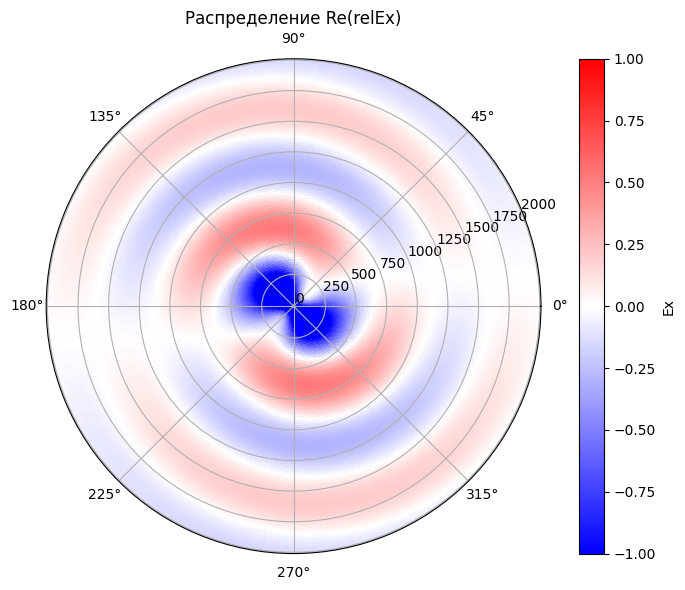

In [19]:
import matplotlib.pyplot as plt
import numpy as np

comp ='Ex'

r_vals = FiledAir.df['r'].apply(lambda x: x.to('nm').magnitude).unique()
phi_vals = FiledAir.df['phi'].apply(lambda x: x.to('rad').magnitude).unique()

r_mesh, phi_mesh = np.meshgrid(r_vals, phi_vals, indexing='ij')

comp_vals = FiledAir.df[comp].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))


exx = FiledAir.df['Ex'].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))


eyy = FiledAir.df['Ey'].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8, 6))


Err = exx * np.cos(phi_mesh) + eyy * np.sin(phi_mesh)

Epp = -1 *  exx * np.sin(phi_mesh) + eyy * np.cos(phi_mesh)

c = ax.pcolormesh(phi_mesh, r_mesh, comp_vals.real , shading='auto', cmap='bwr', vmax=1, vmin=-1)

fig.colorbar(c, ax=ax, label=f"{comp}")

# fig.colorbar(c, ax=ax, label=f"{comp}", format='%.0e')

plt.tight_layout()

ax.set_title(f"Распределение Re(rel{comp})")
plt.tight_layout()
# plt.savefig(f'field/real('+comp+').png', dpi=300 )
plt.show()

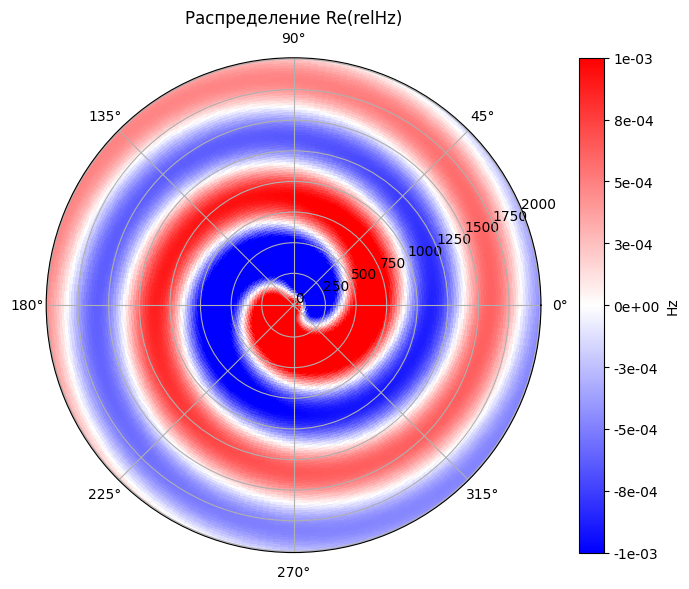

In [53]:
import matplotlib.pyplot as plt
import numpy as np

comp ='Hz'

r_vals = FiledFull.df['r'].apply(lambda x: x.to('nm').magnitude).unique()
phi_vals = FiledFull.df['phi'].apply(lambda x: x.to('rad').magnitude).unique()

r_mesh, phi_mesh = np.meshgrid(r_vals, phi_vals, indexing='ij')

comp_vals = FiledFull.df[comp].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))

hxx = FiledFull.df['Hx'].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))

hyy = FiledFull.df['Hy'].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8, 6))

c = ax.pcolormesh(phi_mesh, r_mesh, comp_vals.imag, shading='auto', cmap='bwr', vmax=1e-3, vmin=-1e-3)


fig.colorbar(c, ax=ax, label=f"{comp}", format='%.0e')



ax.set_title(f"Распределение Re(rel{comp})")
plt.tight_layout()
plt.savefig(f'field/real('+comp+').png', dpi=300 )
plt.show()

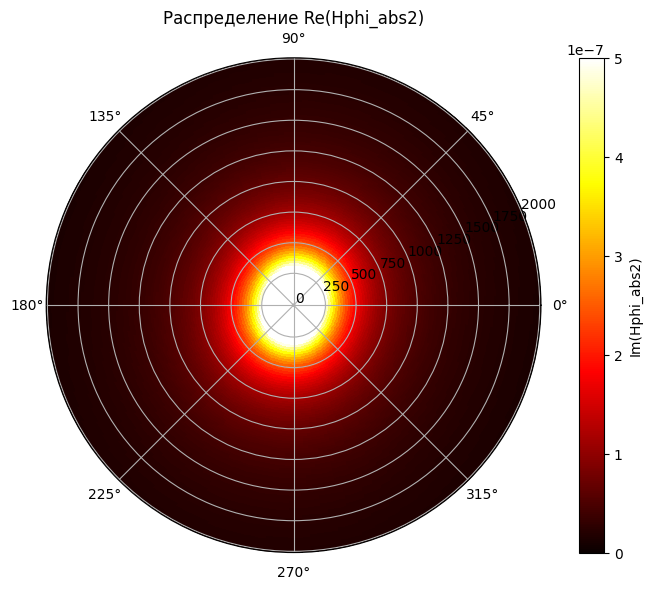

In [20]:
import matplotlib.pyplot as plt
import numpy as np

comp = 'Hphi_abs2'

r_vals = FiledAir.df['r'].apply(lambda x: x.to('nm').magnitude).unique()
phi_vals = FiledAir.df['phi'].apply(lambda x: x.to('rad').magnitude).unique()

r_mesh, phi_mesh = np.meshgrid(r_vals, phi_vals, indexing='ij')

comp_vals = FiledAir.df[comp].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8, 6))

# Построение сырых данных точками
sc = ax.pcolormesh(phi_mesh, r_mesh, comp_vals.real, cmap='hot', vmin=0, vmax=0.5*1e-6)

fig.colorbar(sc, ax=ax, label=f"Im({comp})")

ax.set_title(f"Распределение Re({comp})")
plt.tight_layout()
plt.show()

In [95]:
data = pd.read_csv('relHphi_wl_m.csv', skiprows=4)

wls = data['% lambda0 (nm)'].unique()

phii = np.linspace(0, 2*np.pi, 200)

H_phi = np.zeros((len(wls), len(phii)), dtype=complex)

M_max =2 
for i in range(len(wls)):
    for j in range(2*M_max+1):
        H_phi[i,:] += (data['real(ewfd.relHphi) (A/m), Point: 13'][i*(2*M_max+1)+j] + 1j*data['imag(ewfd.relHphi) (A/m), Point: 13'][i*(2*M_max+1)+j])*np.exp(-1j*(-M_max+j)*phii)

In [97]:
from scipy.integrate import trapezoid
D_coms = np.zeros_like(H_phi)

for i in range(len(wls)):
    integr = trapezoid(np.abs(H_phi[i,:])**2, phii)
    D_coms [i, :] =  2*np.pi* np.abs(H_phi[i,:])**2 /  integr   

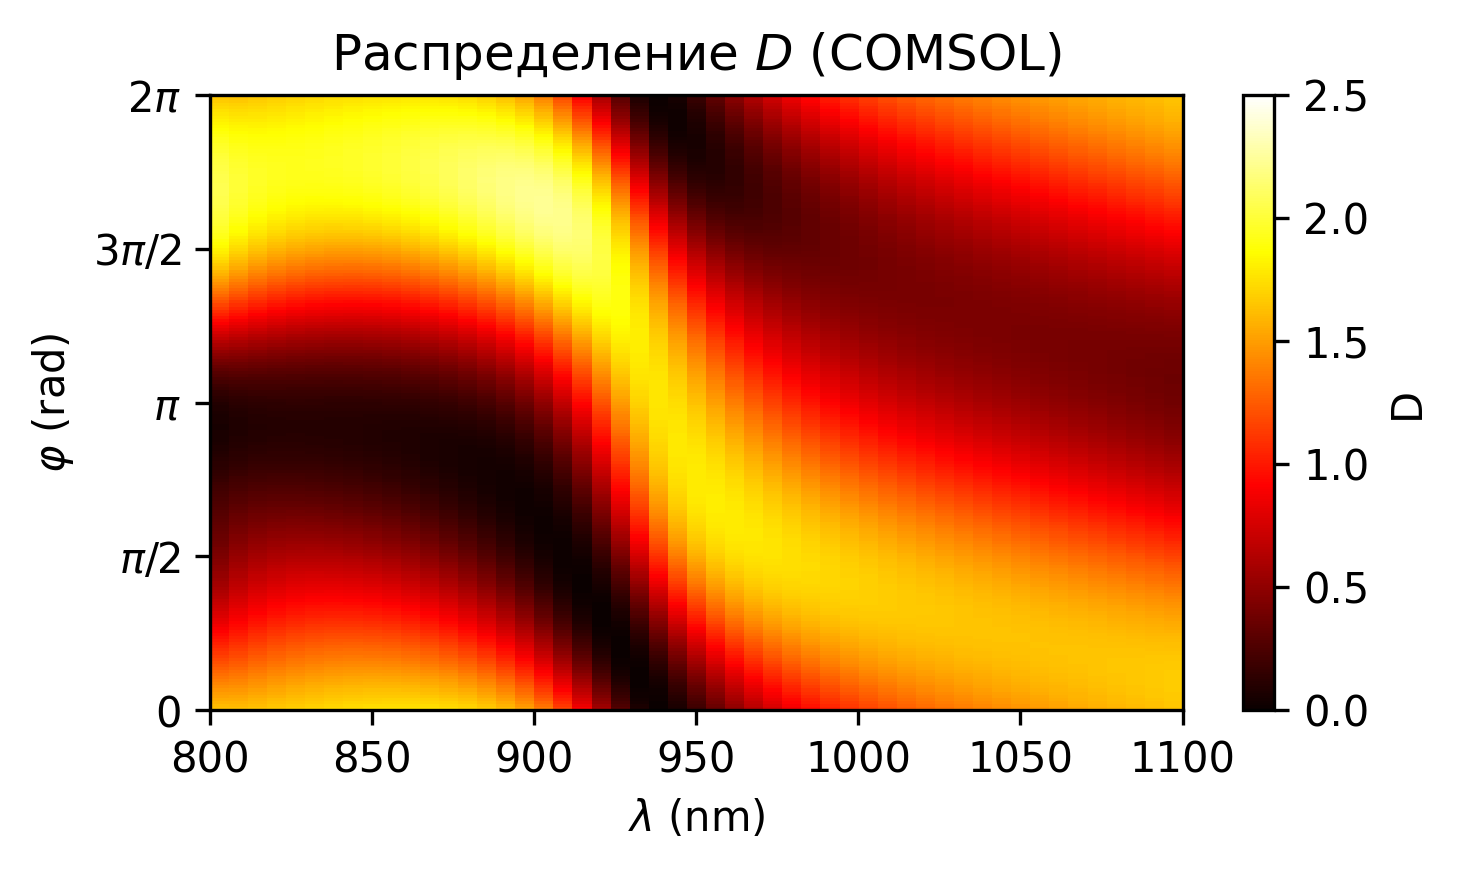

In [100]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3), dpi=300)

plt.imshow(
    D_coms.T.real,
    aspect="auto",
    origin="lower",
    extent=[
        wls[0],   wls[-1],
        phii[0], phii[-1],
    ],
    cmap="hot",
    vmin=0, vmax=2.5
)

plt.colorbar(label="D")
plt.xlabel("$\\lambda$ (nm)")
plt.ylabel("$\\varphi$ (rad)")
plt.title("Распределение $D$ (COMSOL)")

# Установка делений по оси Y в радианах
yticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
yticklabels = ["$0$", "$\\pi/2$", "$\\pi$", "$3\\pi/2$", "$2\\pi$"]

plt.yticks(yticks, yticklabels)

plt.tight_layout()
plt.savefig('D_map_comsol.png')
plt.show()

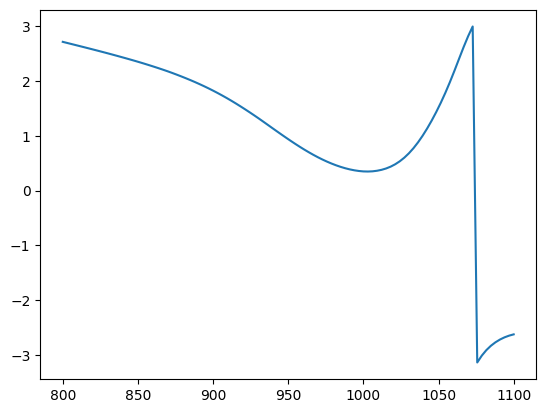

In [37]:
plt.plot(wl, np.atan2(Fycross, Fxcross))

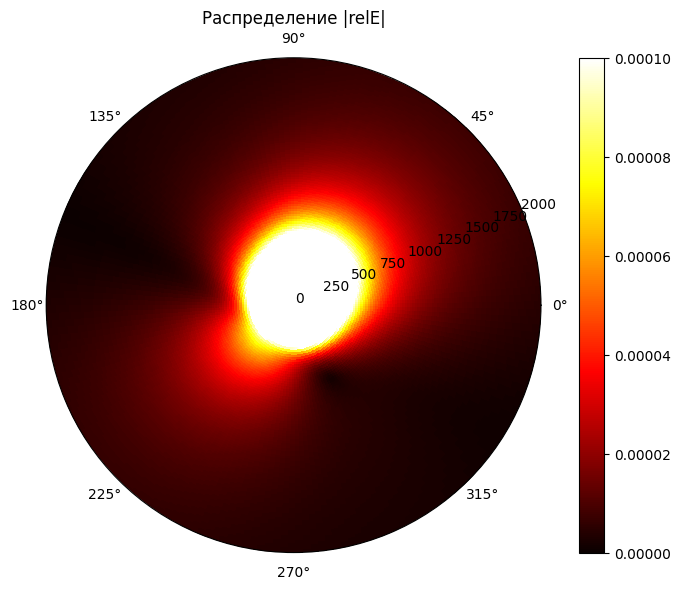

In [46]:
import matplotlib.pyplot as plt
import numpy as np


r_vals = FiledAir.df['r'].apply(lambda x: x.to('nm').magnitude).unique()
phi_vals = FiledAir.df['phi'].apply(lambda x: x.to('rad').magnitude).unique()

r_mesh, phi_mesh = np.meshgrid(r_vals, phi_vals, indexing='ij')

Ex = FiledAir.df['Ex'].apply(lambda x: x.to('V/m').magnitude).values.reshape(len(r_vals), len(phi_vals))
Ey = FiledAir.df['Ey'].apply(lambda x: x.to('V/m').magnitude).values.reshape(len(r_vals), len(phi_vals))
Ez = FiledAir.df['Ez'].apply(lambda x: x.to('V/m').magnitude).values.reshape(len(r_vals), len(phi_vals))

Hx = FiledAir.df['Hx'].apply(lambda x: x.to('A/m').magnitude).values.reshape(len(r_vals), len(phi_vals))
Hy = FiledAir.df['Hy'].apply(lambda x: x.to('A/m').magnitude).values.reshape(len(r_vals), len(phi_vals))
Hz = FiledAir.df['Hz'].apply(lambda x: x.to('A/m').magnitude).values.reshape(len(r_vals), len(phi_vals))

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8, 6))

Sx = 0.5*np.real(Ey*np.conj(Hz) - Ez*np.conj(Hy))
Sy = 0.5*np.real(Ez*np.conj(Hx) - Ex*np.conj(Hz) )
Sz = 0.5* np.real(Ex*np.conj(Hy) - Ey*np.conj(Hz))

#c = ax.pcolormesh(phi_mesh, r_mesh, np.sqrt(Ex*Ex.conj()+Ey*Ey.conj()+Ez*Ez.conj()).real, shading=None, cmap='hot', vmax=0.5, vmin=0)

#c = ax.pcolormesh(phi_mesh, r_mesh, np.sqrt(Hx*Hx.conj()+Hy*Hy.conj()+Hz*Hz.conj()).real, shading=None, cmap='hot', vmin=0, vmax=1e-3)

#c = ax.pcolormesh(phi_mesh, r_mesh, np.abs(Sx*np.cos(phi_mesh)+np.sin(phi_mesh)*Sy)**2, shading=None, cmap='hot',vmax=1e-9, vmin=0)

c = ax.pcolormesh(phi_mesh, r_mesh, np.sqrt(np.abs(Sx)**2 + np.abs(Sy)**2 + np.abs(Sz)**2), shading=None, cmap='hot',vmax=1e-4, vmin=0)


fig.colorbar(c, ax=ax)

ax.set_title(f"Распределение |relE|")
plt.tight_layout()
ax.grid()
plt.show()

In [ ]:
setattr(base_config, 'R', 10*ureg.nm)
Filed_Small = FieldsCalculator(base_config).compute(grid)
setattr(base_config, 'R', (295/2)*ureg.nm)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


r_vals = Filed.df['r'].apply(lambda x: x.to('nm').magnitude).unique()
phi_vals = Filed.df['phi'].apply(lambda x: x.to('rad').magnitude).unique()

r_mesh, phi_mesh = np.meshgrid(r_vals, phi_vals, indexing='ij')

Ex_small = Filed_Small.df['Ex'].apply(lambda x: x.to('V/m').magnitude).values.reshape(len(r_vals), len(phi_vals))
Ey_small = Filed_Small.df['Ey'].apply(lambda x: x.to('V/m').magnitude).values.reshape(len(r_vals), len(phi_vals))
Ez_small = Filed_Small.df['Ez'].apply(lambda x: x.to('V/m').magnitude).values.reshape(len(r_vals), len(phi_vals))

Hx_small = Filed_Small.df['Hx'].apply(lambda x: x.to('A/m').magnitude).values.reshape(len(r_vals), len(phi_vals))
Hy_small = Filed_Small.df['Hy'].apply(lambda x: x.to('A/m').magnitude).values.reshape(len(r_vals), len(phi_vals))
Hz_small = Filed_Small.df['Hz'].apply(lambda x: x.to('A/m').magnitude).values.reshape(len(r_vals), len(phi_vals))

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8, 6))

normE_small = np.sqrt(Ex_small*Ex_small.conj() + Ey_small*Ey_small.conj() + Ez_small*Ez_small.conj())

c = ax.pcolormesh(phi_mesh, r_mesh, Ex_small.real, shading='auto', cmap='bwr')

fig.colorbar(c, ax=ax)

ax.set_title(f"Распределение Re(Ex)")
plt.tight_layout()
ax.grid()
plt.show()

In [ ]:
from MieSppForce import green_func, frenel


eps_Au = frenel.get_interpolate('Au')
wl = 900
z0 = 149.5
r = np.sqrt(1000**2 + 1000**2)
phi = np.pi/4
z=1000
STOP = 35

GE = green_func.getGE(wl, eps_Au, z0, r, phi, z,  STOP)

In [ ]:
print(np.array_str(GE, precision=3))

In [ ]:
base_config.get_eps_substrate()